# Fundamentals of machine transcription

In this lab, you will play around with image degradation, OCR, and transcription quality. This notebook is written so that all cells can be run at any time (with the obvious exception that you mut first load some data before manipulating it). In the "runtime" menu above, you can restart your instance of the virtual machine that your code is being run on.

There will be no hand-ins or reports for this lab. I consider those a necesary evil for lab that should be about experimentation. Put your time into reading the application papers in the slides, play around with this notebook (maybe adding your own text or images), and discuss the technology during the lab and digital office hours.

If you want to learn more about programming, the [python website](https://www.python.org/about/gettingstarted/) (which has some introduction for beginners) and [the programming historian](https://programminghistorian.org/en/lessons/). These are also several courses on programming at UU and other universities. The most important thing might be to find something you would like to do and then learn what's needed.

## Setting up the virtual machine

The code cell below will install and load all the necessary software for this lab on your current virtual machine on colab. A virtual machine will automatically be created for you when you run something. Simply press play :)

If you want to run this on *your own machine*, you will need to have the packages tesseract (for OCR) and pytesseract (tesseract python bindings) installed. If you are working in colab, the next code cell will set up your environment. You can install pytesseract by running ```pip3 install --user pytesseract``` in your terminal. More information on the OCR software packages can be found on [pypi](https://pypi.org/project/pytesseract/) and [wikipedia](https://en.wikipedia.org/wiki/Tesseract_(software)). For running you own python environment, I recommend using the [anaconda python distribution](https://www.anaconda.com/products/individual).

In [ ]:
language_models = ['eng', 'swe']

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Base package
  !apt install tesseract-ocr
  # Swedish language model
  for lang in language_models:
    if lang != 'eng':
      !apt install tesseract-ocr-{lang}
  # Python bindings
  !pip install pytesseract
  # git repo with images and some more code
  !git clone https://github.com/fredrikwahlberg/5KK056.git
  # Enter the repo folder
  %cd /content/5KK056

import cv2                        # Computer Vision
import numpy as np                # Vector math
import pytesseract                # OCR
import os.path                    # File system stuff
from levenshtein import wer, cer  # Error metrics for strings
import ipywidgets as widgets      # For interactivity

# We will need a list of the font availible for OpenCV
fonts = [("FONT_HERSHEY_SIMPLEX", cv2.FONT_HERSHEY_SIMPLEX),
         ("FONT_HERSHEY_PLAIN", cv2.FONT_HERSHEY_PLAIN),
         ("FONT_HERSHEY_DUPLEX", cv2.FONT_HERSHEY_DUPLEX),
         ("FONT_HERSHEY_COMPLEX", cv2.FONT_HERSHEY_COMPLEX),
         ("FONT_HERSHEY_TRIPLEX", cv2.FONT_HERSHEY_TRIPLEX),
         ("FONT_HERSHEY_COMPLEX_SMALL", cv2.FONT_HERSHEY_COMPLEX_SMALL),
         ("FONT_HERSHEY_SCRIPT_SIMPLEX", cv2.FONT_HERSHEY_SCRIPT_SIMPLEX),
         ("FONT_HERSHEY_SCRIPT_COMPLEX", cv2.FONT_HERSHEY_SCRIPT_COMPLEX),
         ("FONT_ITALIC", cv2.FONT_ITALIC)]

import matplotlib.pyplot as plt   # Plotting, the line after this one is only for jupyter notebook
%matplotlib inline

chosen_language_model = None

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,521 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../tesserac

## Load data

The following cells will load some data for you to work with.

*Note that the following cells will overwrite each other. Running two of them will only keep the latest loaded data.*

### Eisenhower's militaty industrial complex speech

A part of Eisenhower's famous speech about the influence of the military industrial complex. These issues are of course solved now after the 2020 election...

In [ ]:
original_image = cv2.imread("Eisenhower.png", cv2.IMREAD_GRAYSCALE)
image = original_image.copy()

with open("Eisenhower.txt", 'r') as file:
    golden_transcription = file.read()
transcription = None

print("Loaded")

Loaded


### An old encyclopedia entry on Gutenberg

This image is from an old Swedish encyclopedia on Gutenberg. It could be worth thinking about when running the OCR that this is written in swedish.

In [ ]:
original_image = cv2.imread("Gutenberg.png", cv2.IMREAD_GRAYSCALE)
image = original_image.copy()

with open("Gutenberg.txt", 'r', encoding='utf-8') as file:
    golden_transcription = file.read()
transcription = None

print("Loaded")

Loaded


### Generate an image from text

This cell generates and image from the text in the ```txt``` variable. Try changing it to something else. If you want to write something in another language than swedish or english, you will need to load a new language model for OCR quality. You can do this by adding the three letter language code (ISO standard) to the ```language_models``` list in the first code cell then running it.






In [ ]:
golden_transcription = """Shall I compare thee to a summer's day?
Thou art more lovely and more temperate:
Rough winds do shake the darling buds of May,
And summer's lease hath all too short a date:
Sometime too hot the eye of heaven shines,
And often is his gold complexion dimmed;
And every fair from fair sometime declines,
By chance, or nature's changing course, untrimmed:
But thy eternal summer shall not fade,
Nor lose possession of that fair thou ow'st;
Nor shall Death brag thou wander'st in his shade
When in eternal lines to time thou grow'st:
So long as men can breathe or eyes can see,
So long lives this, and this gives life to thee."""

def render_text(font, scale):
  global image, original_image, golden_transcription
  image = np.zeros((2000, 2000), dtype=np.uint8)
  # Render text lines
  y = 100
  for i, textline in enumerate(golden_transcription.split('\n')):
    cv2.putText(image, textline.strip(), (100, y), fontFace=font, fontScale=scale, color=(255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    res = cv2.getTextSize(textline, fontFace=font, fontScale=scale, thickness=1)
    y += res[0][1]+res[1]
  # Trip the image
  while np.sum(image[:, :5]) == 0:
    image = image[:, 2:]
  while np.sum(image[:, -5:]) == 0:
    image = image[:, :-2]
  while np.sum(image[:5, :]) == 0:
    image = image[2:, :]
  while np.sum(image[-5:, :]) == 0:
    image = image[:-2, :]
  # Invert colours
  image = 255-image
  # Plot
  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='gray')
  plt.show()
  original_image = image.copy()

widgets.interact(render_text, font=fonts, scale=widgets.FloatSlider(min=.1, max=1.5, step=.1, value=1));

interactive(children=(Dropdown(description='font', options=(('FONT_HERSHEY_SIMPLEX', 0), ('FONT_HERSHEY_PLAIN'…

### Your own image

You can use the following cell to load your own data. Upload a text file called ```my_transcription.txt``` and an image file ```my_transcription.png``` (or ```my_transcription.jpg```) to the virtual machine. Then run the cell. You can upload files using the file dialog to the left (where you have the table of contents).



In [ ]:
if os.path.exists("my_transcription.txt") and (os.path.exists("my_image.png") or os.path.exists("my_image.jpg")):
  if os.path.exists("my_image.png"):
    original_image = cv2.imread("my_image.png", cv2.IMREAD_GRAYSCALE)
  else:
    original_image = cv2.imread("my_image.jpg", cv2.IMREAD_GRAYSCALE)
  image = original_image.copy()

  with open("my_transcription.txt", 'r', encoding='utf-8') as file:
      golden_transcription = file.read()
  transcription = None
  
  print("Loaded")
else:
  print("File(s) not found")

File were not found


### Show the currently loaded data

This shows whetever is loaded at the moment. If you were to run this code before loading any data, it would return an error and say that the data variable for the original image doesn't exist.

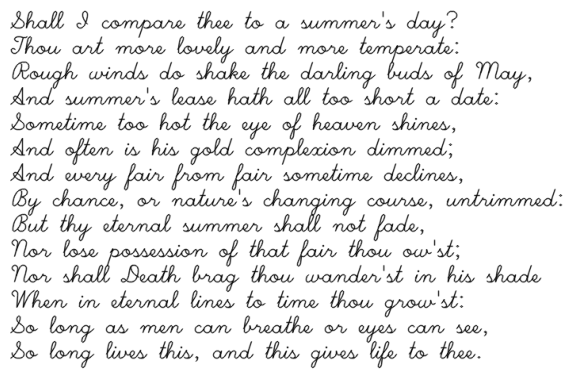

Shall I compare thee to a summer's day?
Thou art more lovely and more temperate:
Rough winds do shake the darling buds of May,
And summer's lease hath all too short a date:
Sometime too hot the eye of heaven shines,
And often is his gold complexion dimmed;
And every fair from fair sometime declines,
By chance, or nature's changing course, untrimmed:
But thy eternal summer shall not fade,
Nor lose possession of that fair thou ow'st;
Nor shall Death brag thou wander'st in his shade
When in eternal lines to time thou grow'st:
So long as men can breathe or eyes can see,
So long lives this, and this gives life to thee.


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(original_image, cmap='gray')
plt.axis('off')
plt.show()
print(golden_transcription)

## Modify data

### Degradation tool



In [ ]:
def resize_and_compress(scale, quality):
  global image, original_image
  # Resize the image
  new_dimensions = (int(original_image.shape[1]*scale/100),
                    int(original_image.shape[0]*scale/100))
  original_dimensions = (original_image.shape[1], original_image.shape[0])
  downscaled_image = cv2.resize(original_image, new_dimensions, interpolation=cv2.INTER_LANCZOS4)
  # print("Resolution is %.1f Mpix (down from the original %.fMpix)" % (np.prod(new_dimensions)/1e6, np.prod(original_dimensions)/1e6))
  # Compress
  result, compressed_image = cv2.imencode('.jpg', downscaled_image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
  decompressed_image = cv2.imdecode(compressed_image, 1)
  # print("Compression ratio %.1f" % (decompressed_image.nbytes/compressed_image.nbytes))
  # print("Space saving %.1f%%" % (100*(1-compressed_image.nbytes/decompressed_image.nbytes)))
  # Show the image
  image = decompressed_image
  plt.figure(figsize=(7, 7))
  plt.imshow(image)
  plt.show()

widgets.interact(resize_and_compress, scale=widgets.IntSlider(min=1, max=100, step=1, value=100), quality=widgets.IntSlider(min=1, max=100, step=1, value=100));

interactive(children=(IntSlider(value=100, description='scale', min=1), IntSlider(value=100, description='qual…

## Measure the OCR quality

The following are some cells ffor visualising and analysing the OCR quality.

### Running the OCR

The runs the OCR. Notice how short this code cell is. Only one line is needed to call the OCR engine. The rest is connected to the widget which makes you able to choose the language model interactively (whichout changing the code).

In [ ]:
def transcribe(lang):
  global transcription, chosen_language_model
  chosen_language_model = lang
  print("Running OCR... ", end="")
  transcription = pytesseract.image_to_string(image, lang=lang)
  print("done")
  print(transcription)

widgets.interact(transcribe, lang=widgets.widgets.Dropdown(
    options=language_models, value=language_models[0], description='Language:'));

interactive(children=(Dropdown(description='Language:', options=('eng', 'swe'), value='eng'), Output()), _dom_…

### Testing the OCR quality

A common metric of quality of the OCR is the word/character error rate (WER/CER), i.e. the number of non-recognised words/characters in relation to the total number of words/characters. This can be done by flexibly matching the original text with the text returned from the OCR using the so called Levenshtein distance. The Levenshtein distance is a distance metric between sequences of symbols where the distance is number of edit operations required for transforming one sequence of symbols into another sequence. In our case, this is equal to how many charcters or words need to be removed, added, or changed to transform one string into another.

In [ ]:
we = wer(golden_transcription, transcription)
print("Word level errors")
print(golden_transcription.split())
print(transcription.split())
print("Word errors:", we[0])
print("WER: %.1f%%" % (we[1]*100))
print()
ce = cer(golden_transcription, transcription)
print("Character level errors")
print(list(golden_transcription))
print(list(transcription))
print("Character errors:", ce[0])
print("CER: %.1f%%" % (ce[1]*100))

Word level errors
['Shall', 'I', 'compare', 'thee', 'to', 'a', "summer's", 'day?', 'Thou', 'art', 'more', 'lovely', 'and', 'more', 'temperate:', 'Rough', 'winds', 'do', 'shake', 'the', 'darling', 'buds', 'of', 'May,', 'And', "summer's", 'lease', 'hath', 'all', 'too', 'short', 'a', 'date:', 'Sometime', 'too', 'hot', 'the', 'eye', 'of', 'heaven', 'shines,', 'And', 'often', 'is', 'his', 'gold', 'complexion', 'dimmed;', 'And', 'every', 'fair', 'from', 'fair', 'sometime', 'declines,', 'By', 'chance,', 'or', "nature's", 'changing', 'course,', 'untrimmed:', 'But', 'thy', 'eternal', 'summer', 'shall', 'not', 'fade,', 'Nor', 'lose', 'possession', 'of', 'that', 'fair', 'thou', "ow'st;", 'Nor', 'shall', 'Death', 'brag', 'thou', "wander'st", 'in', 'his', 'shade', 'When', 'in', 'eternal', 'lines', 'to', 'time', 'thou', "grow'st:", 'So', 'long', 'as', 'men', 'can', 'breathe', 'or', 'eyes', 'can', 'see,', 'So', 'long', 'lives', 'this,', 'and', 'this', 'gives', 'life', 'to', 'thee.']
['dhall', '3', 't

### Trying WER and CER

Change the strings in the widget below to experiment with word/character error rates.

In [ ]:
def difference(text1, text2):
  print("%i character level edit operations are needed" % cer(text1, text2)[0])
  print("%i word level edit operations are needed" % wer(text1, text2)[0])

widgets.interact(difference, 
                 text1=widgets.Text(value='This text is spelled correctly', placeholder='Type something', description='Text 1:'), 
                 text2=widgets.Text(value='This textis spleled corecty', placeholder='Type something2', description='Text 2:',));

interactive(children=(Text(value='This text is spelled correctly', description='Text 1:', placeholder='Type so…

## Visualise the OCR results

### Show the character boxes

The image given to tesseract goes though layout analysis (as discussed in the lecture) before returning a string. We can get this data from tesseract if we ask for it.

First, the image will be cropped for simplifying the example.

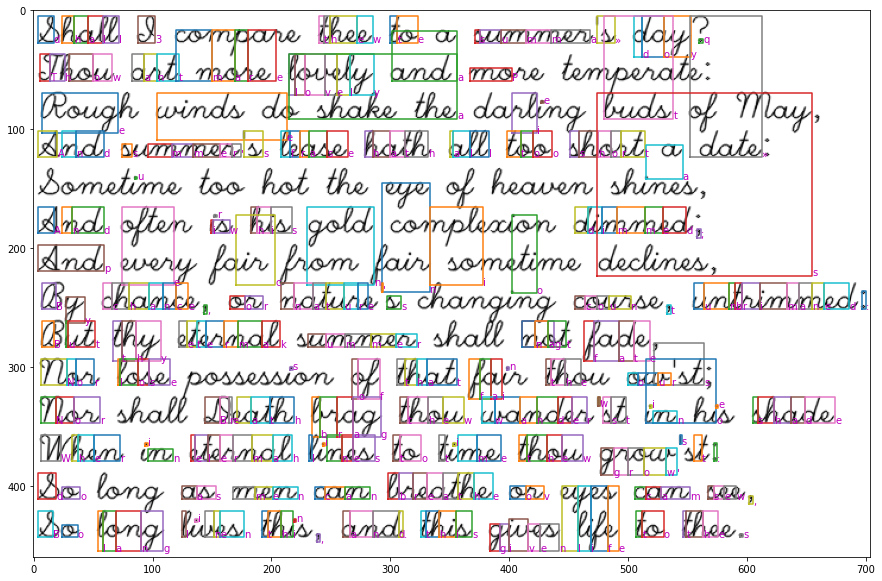

In [ ]:
character_boxes = pytesseract.image_to_boxes(image, lang=chosen_language_model)

plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')
for entry in character_boxes.split("\n"):
  if len(entry) > 0:
    char, y1, x1, y2, x2, _ = entry.split()
    y1 = int(y1)
    y2 = int(y2)
    x1 = image.shape[0]-int(x1)
    x2 = image.shape[0]-int(x2)
    plt.plot([y1, y2, y2, y1, y1], [x1, x1, x2, x2, x1]) # Plot the box
    plt.text(y2, x1, char, color='m') # Plot the OCRed character
plt.show()

### Show the boxes of the words and lines

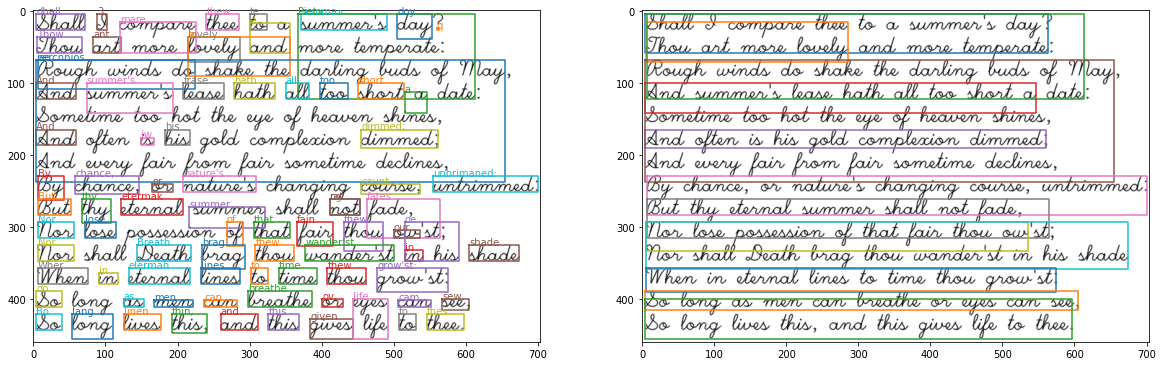

In [ ]:
word_boxes = pytesseract.image_to_data(image, lang=chosen_language_model)

fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image, cmap='gray')
for i, entry in enumerate(word_boxes.split("\n")[1:]):
  e = entry.split()
  if len(e) >= 11:
    level = int(e[0])
    if int(level) == 4:
      # Lines
      _, _, _, _, _, _, y1, x1, y2, x2, _ = e
      y1 = int(y1)
      y2 = int(y2) + y1
      x1 = int(x1)
      x2 = int(x2) + x1
      ax[1].plot([y1, y2, y2, y1, y1], [x1, x1, x2, x2, x1]) # Plot the box
    elif level == 5 and len(e) == 12:
      # Words
      _, _, _, _, _, _, y1, x1, y2, x2, _, text = e
      y1 = int(y1)
      y2 = int(y2) + y1
      x1 = int(x1)
      x2 = int(x2) + x1
      ax[0].plot([y1, y2, y2, y1, y1], [x1, x1, x2, x2, x1], color="C%i" % i) # Plot the box
      ax[0].text(y1, x1, text, color="C%i" % i) # Plot the OCRed character
fig.show()